# Adaptation as a cause of sequence reversal
In this network I want to study the relationship between adaptation and sequence reversal. In a previous notebook I discovered that when I **reset adaptation before the recalling phase sequence reversal appears** In this Notebook I will check the evolution of adaptation for the first hypercolumn in more detail in order to better understand the nature of the effect.

As usual we start this by loading all the required libraries

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from network import BCPNN
from data_transformer import build_ortogonal_patterns
from analysis_functions import calculate_angle_from_history
from analysis_functions import calculate_winning_pattern_from_distances, calculate_patterns_timings

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

#### Git training

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '127d8b9e08a368243e1775da92c304e74fc551e7'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Build the patterns and train the network
Firs we store n_patterns in a network of size hypercolumns * minicolumns

In [3]:
hypercolumns = 10
minicolumns = 10
n_patterns = 10  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
nn = BCPNN(hypercolumns, minicolumns)
nn.k = 1.0
nn.randomize_pattern()

nn.get_parameters()

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'k': 1.0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.24,
 'tau_z_pre': 0.24}

In [4]:
dt = 0.001
T_training = 1.0
training_time = np.arange(0, T_training + dt, dt)

for pattern in patterns:
    print('trained')
    nn.run_network_simulation(training_time, I=pattern, save=True)

trained
trained
trained
trained
trained
trained
trained
trained
trained
trained


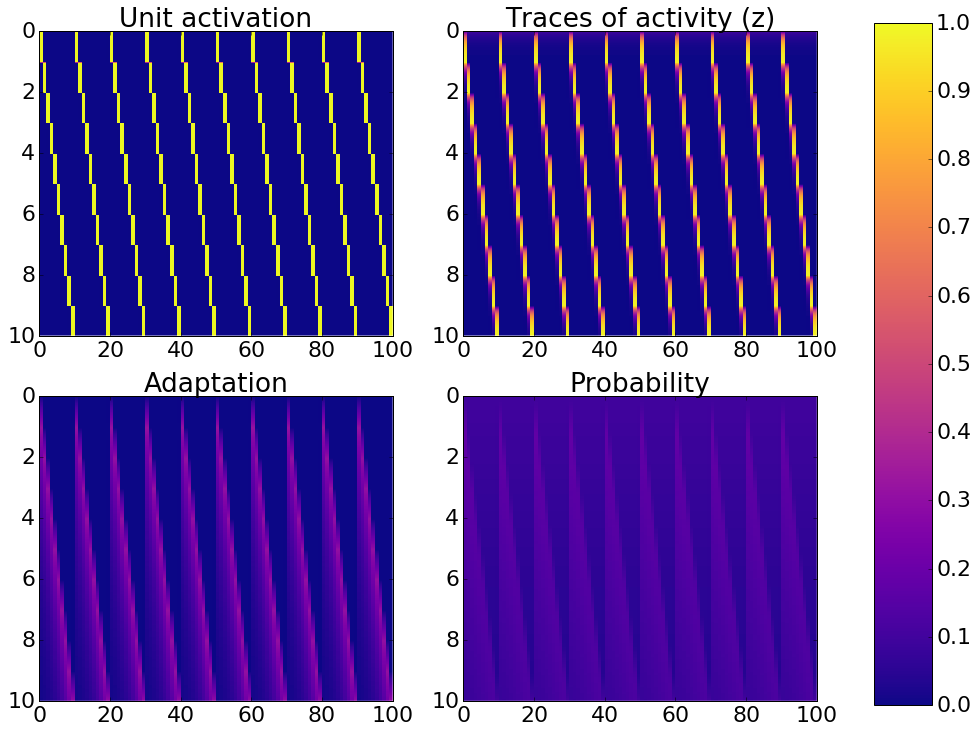

In [5]:
history = nn.history

cmap = 'plasma'
extent = [0, minicolumns * hypercolumns, n_patterns * T_training, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(history['o'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(history['z_post'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity (z)')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(history['a'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(history['p_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

#### Now we check the adaptation

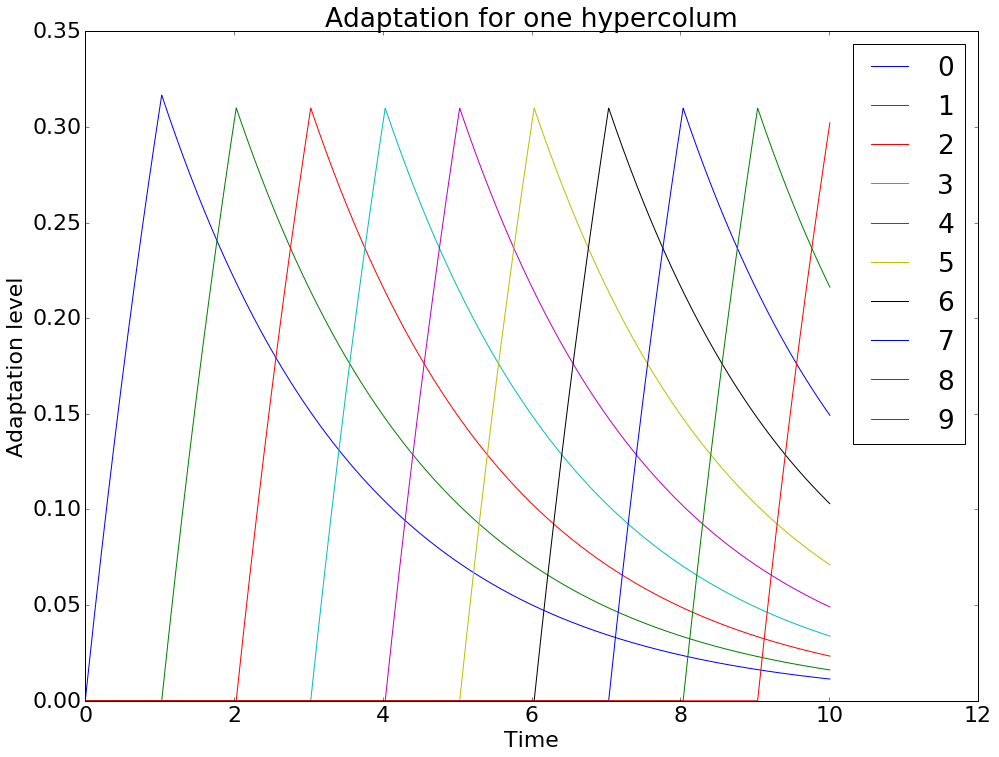

In [6]:
a = history['a']
hypercolum = 0
# a_first = a[:, hypercolum*minicolumns:(hypercolum + 1)*minicolumns + minicolumns]
a_first = a[:, 0:minicolumns]
time_aux = np.arange(0, n_patterns * (T_training + dt), dt)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, a_unit in enumerate(a_first.T):
    ax.plot(time_aux, a_unit, label=str(unit))

ax.set_title('Adaptation for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Adaptation level')
ax.legend()

#### Unit support

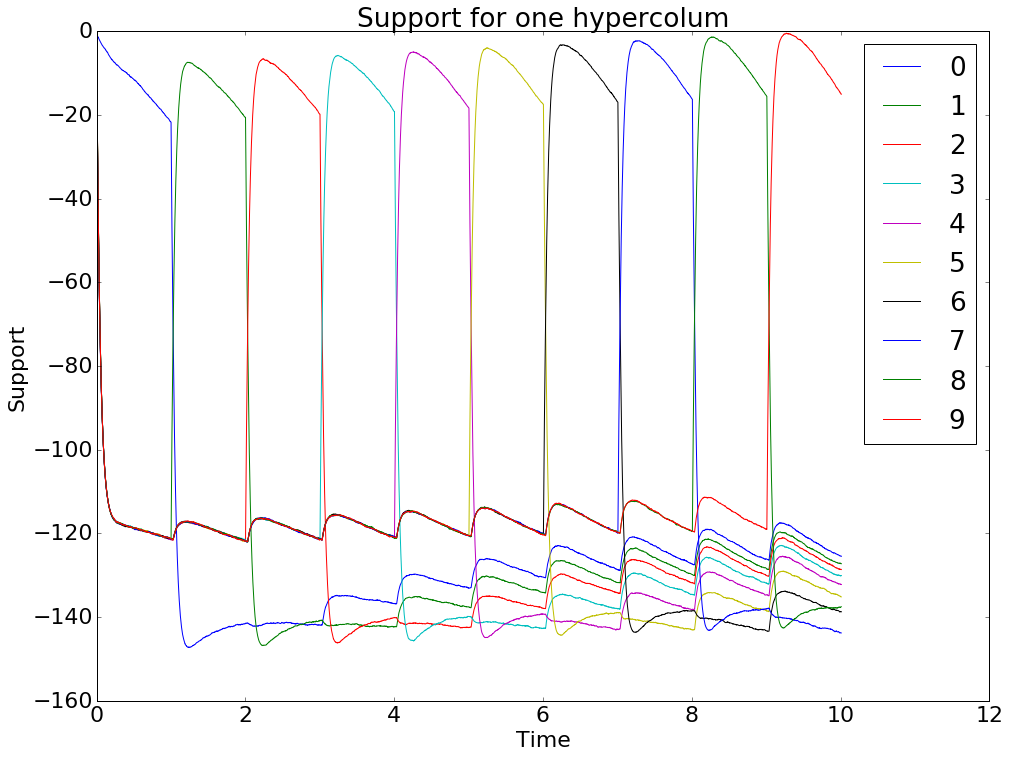

In [7]:
s = history['s']
hypercolum = 0
time_aux = np.arange(0, n_patterns * (T_training + dt), dt)
s_first = s[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, s_unit in enumerate(s_first.T):
    ax.plot(time_aux, s_unit, label=str(unit))

ax.set_title('Support for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Support')
ax.legend()

#### Unit activity

(-0.1, 1.1)

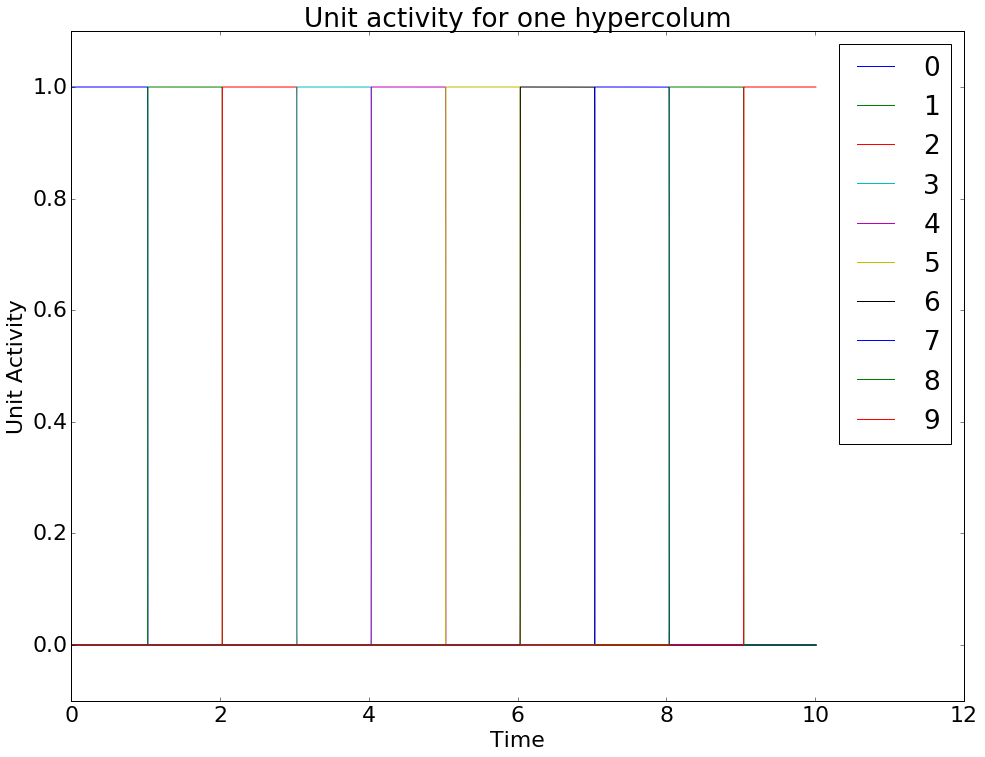

In [8]:
o = history['o']
hypercolum = 0
o_first = o[:, 0:minicolumns]
time_aux = np.arange(0, n_patterns * (T_training + dt), dt)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, o_unit in enumerate(o_first.T):
    ax.plot(time_aux, o_unit, label=str(unit))

ax.set_title('Unit activity for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Unit Activity')
ax.legend()

ax.set_ylim([-0.1, 1.1])

## Recall

In [9]:
# Time 
T_recalling = 10.0
recalling_time = np.arange(0, T_recalling + dt, dt)

# Reinitialize parameters
nn.k = 0
nn.empty_history()
# nn.reset_values(keep_connectivity=True)
# nn.randomize_pattern()
history = nn.run_network_simulation(time=recalling_time, save=True)

# Print parameters
nn.get_parameters()

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'k': 0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.24,
 'tau_z_pre': 0.24}

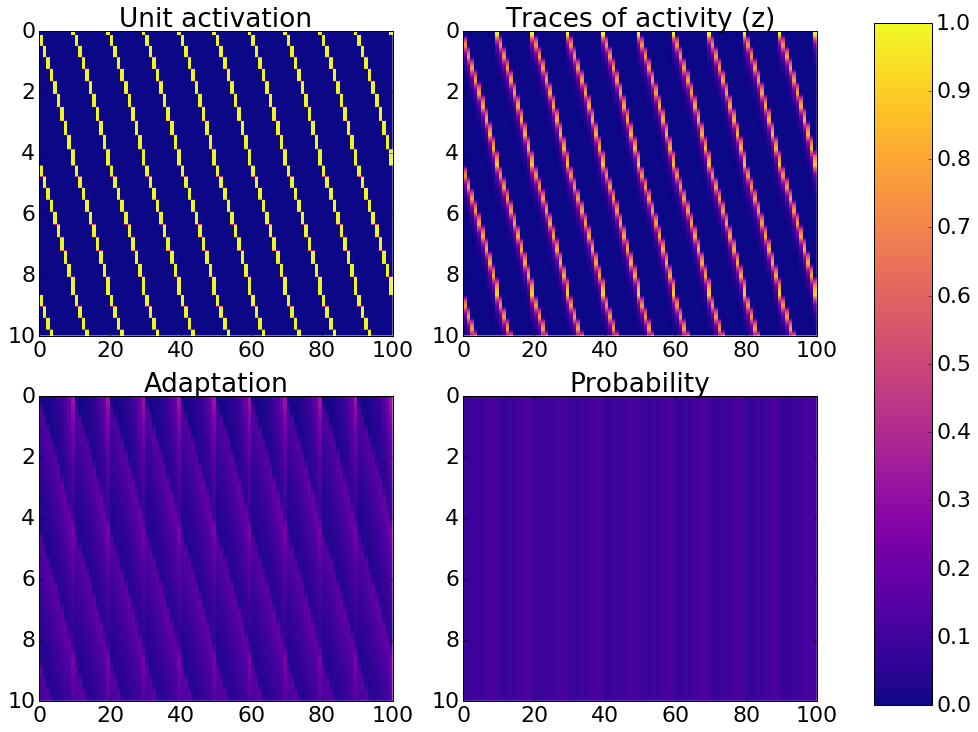

In [10]:
cmap = 'plasma'
extent = [0, minicolumns * hypercolumns, T_recalling, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(history['o'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(history['z_post'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity (z)')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(history['a'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(history['p_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

#### Adaptation 

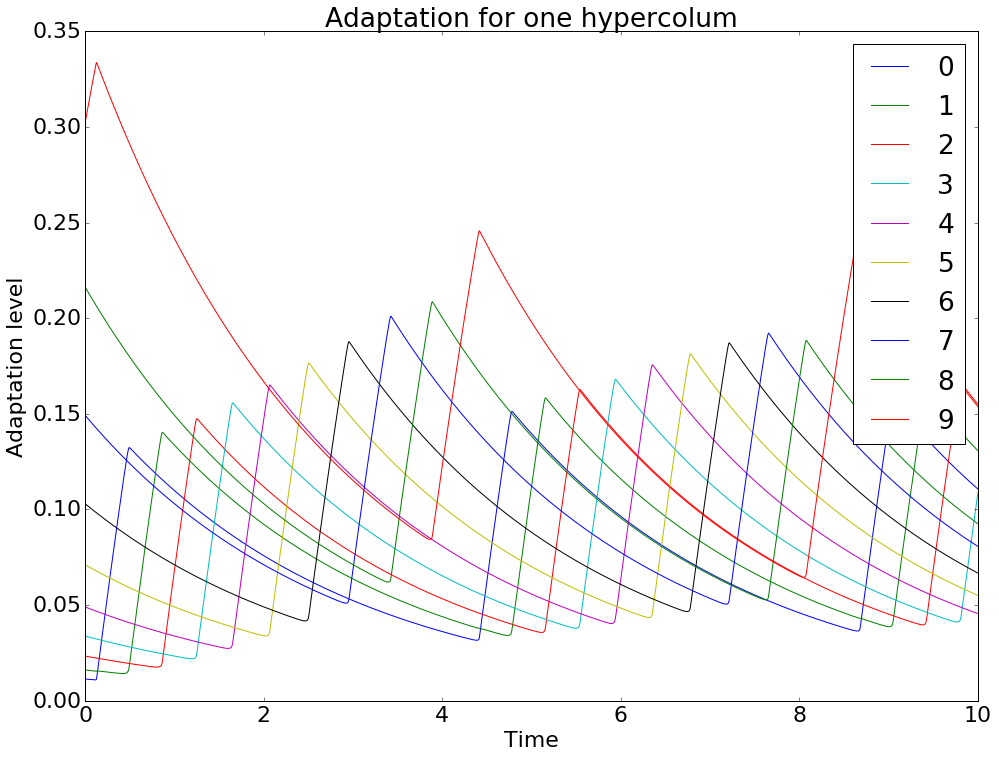

In [11]:
a = history['a']
hypercolum = 0
# a_first = a[:, hypercolum*minicolumns:(hypercolum + 1)*minicolumns + minicolumns]
a_first = a[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, a_unit in enumerate(a_first.T):
    ax.plot(recalling_time, a_unit, label=str(unit))

ax.set_title('Adaptation for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Adaptation level')
ax.legend()

#### Support

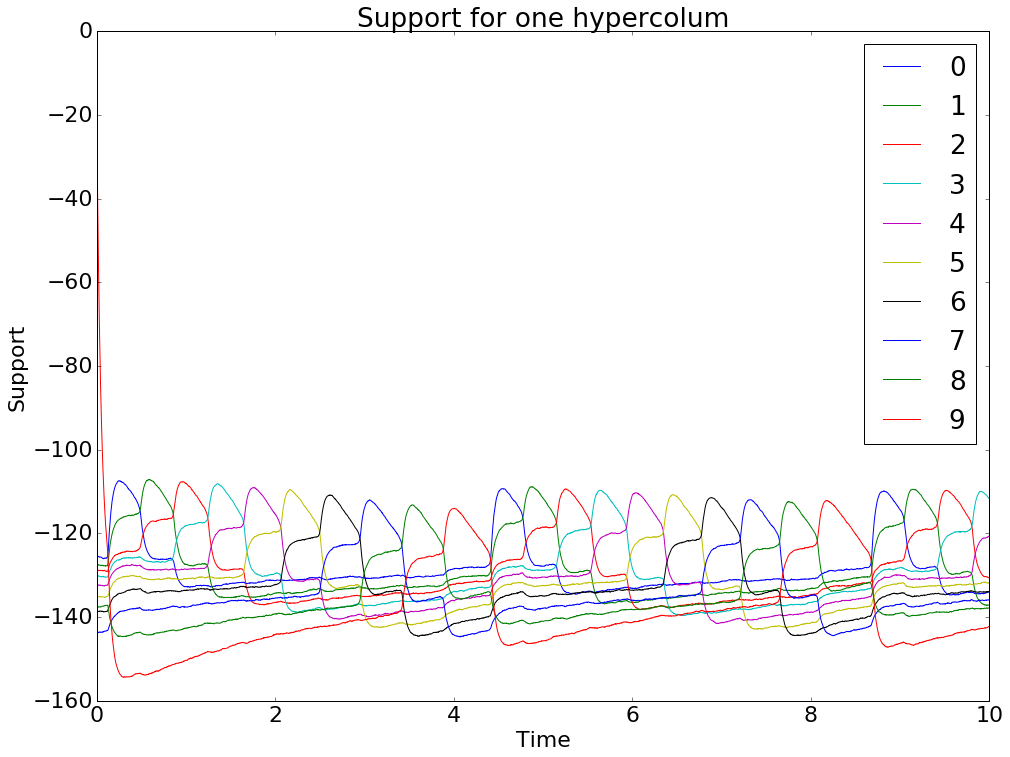

In [12]:
s = history['s']
hypercolum = 0
# a_first = a[:, hypercolum*minicolumns:(hypercolum + 1)*minicolumns + minicolumns]
s_first = s[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, s_unit in enumerate(s_first.T):
    ax.plot(recalling_time, s_unit, label=str(unit))

ax.set_title('Support for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Support')
ax.legend()

#### Unit Activity

(-0.1, 1.1)

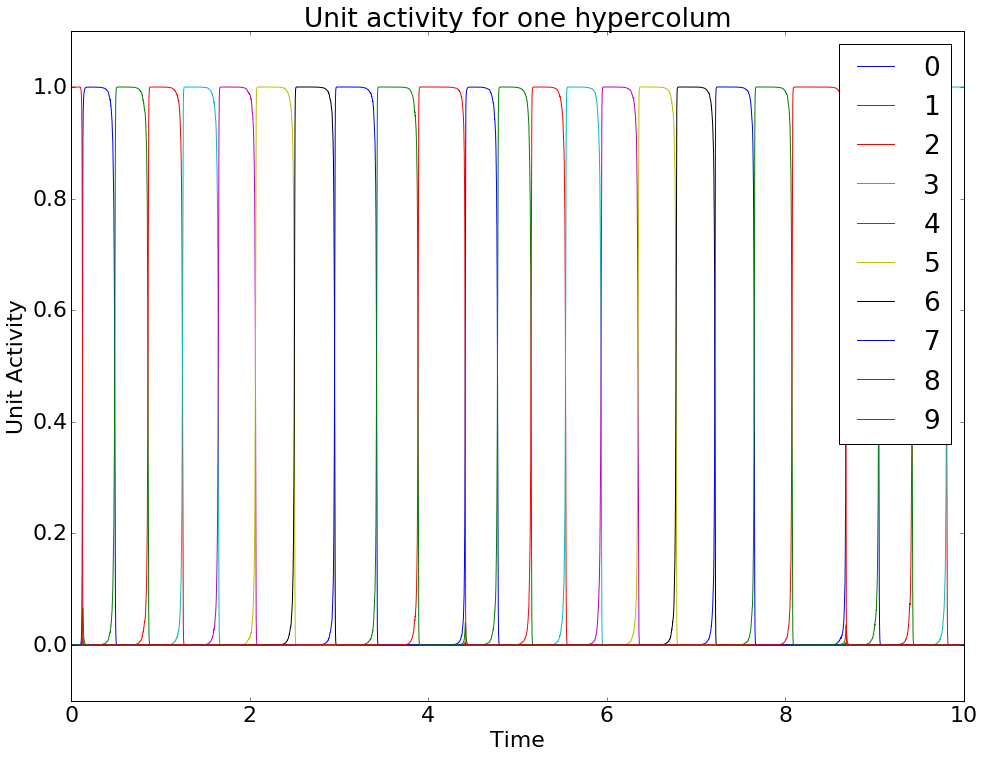

In [13]:
o = history['o']
hypercolum = 0
o_first = o[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, o_unit in enumerate(o_first.T):
    ax.plot(recalling_time, o_unit, label=str(unit))

ax.set_title('Unit activity for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Unit Activity')
ax.legend()


ax.set_ylim([-0.1, 1.1])

## Empty history

In [14]:
# Reinitialize parameters
nn.k = 0
nn.empty_history()
nn.reset_values(keep_connectivity=True)
# nn.randomize_pattern()
history = nn.run_network_simulation(time=recalling_time, save=True)

# Print parameters
nn.get_parameters()

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1,
 'k': 0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.24,
 'tau_z_pre': 0.24}

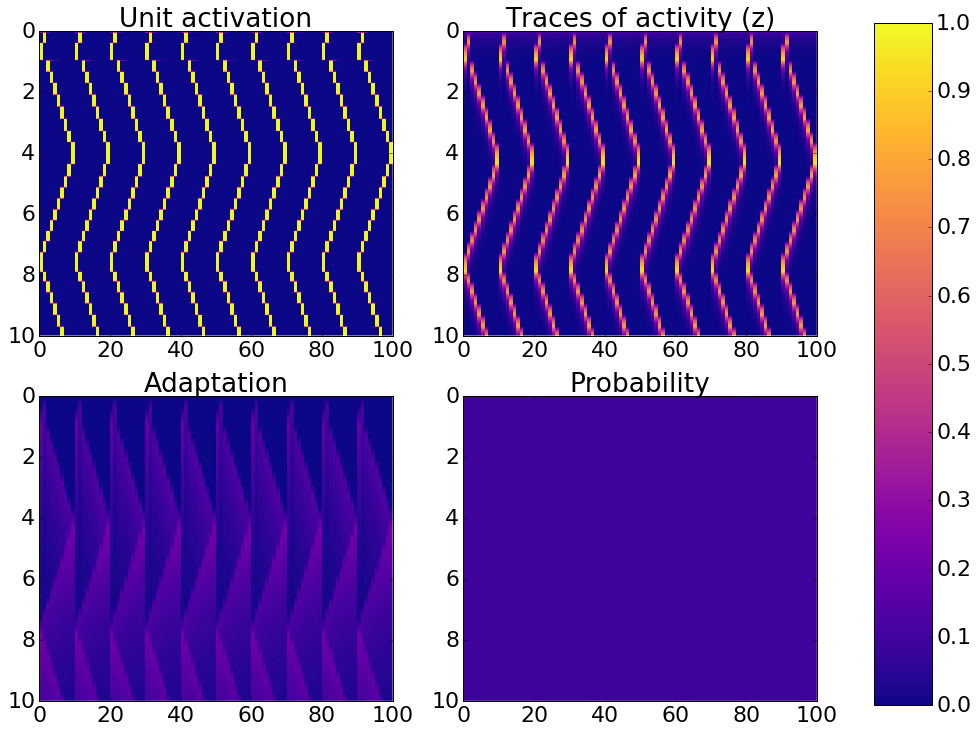

In [15]:
cmap = 'plasma'
extent = [0, minicolumns * hypercolumns, T_recalling, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(history['o'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(history['z_post'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity (z)')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(history['a'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(history['p_pre'], aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

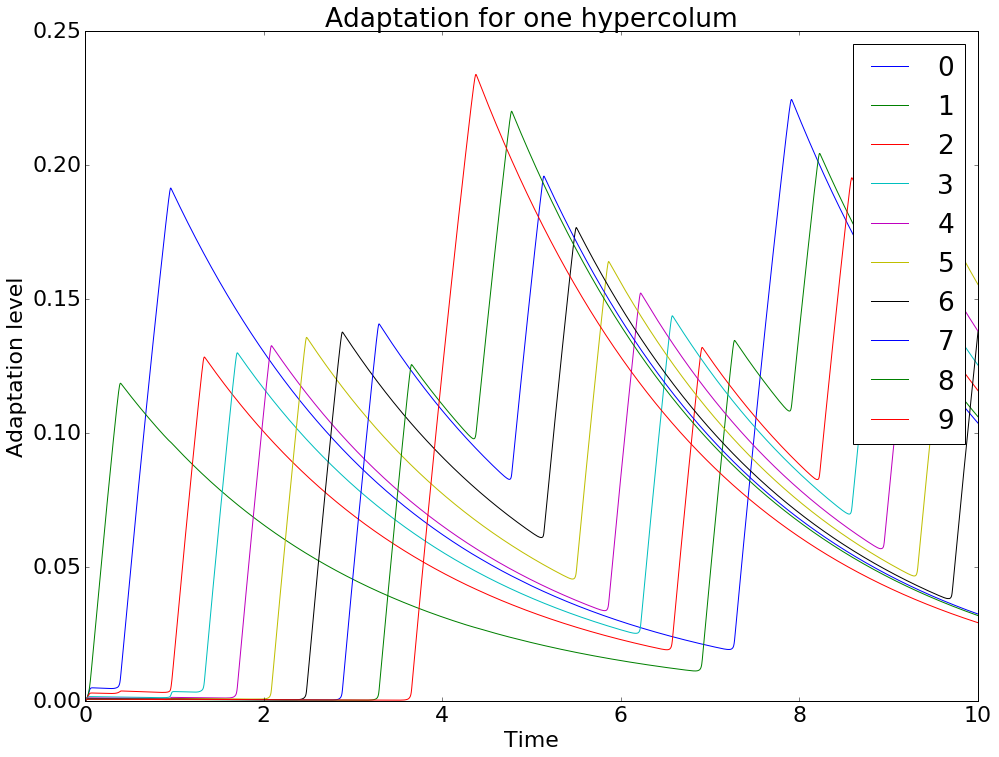

In [16]:
a = history['a']
hypercolum = 0
# a_first = a[:, hypercolum*minicolumns:(hypercolum + 1)*minicolumns + minicolumns]
a_first = a[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, a_unit in enumerate(a_first.T):
    ax.plot(recalling_time, a_unit, label=str(unit))

ax.set_title('Adaptation for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Adaptation level')
ax.legend()
# ax.set_ylim([0.15,0.25])
# ax.set_ylim([-140, -100])
# ax.set_xlim([2.5, 4])

#### Support

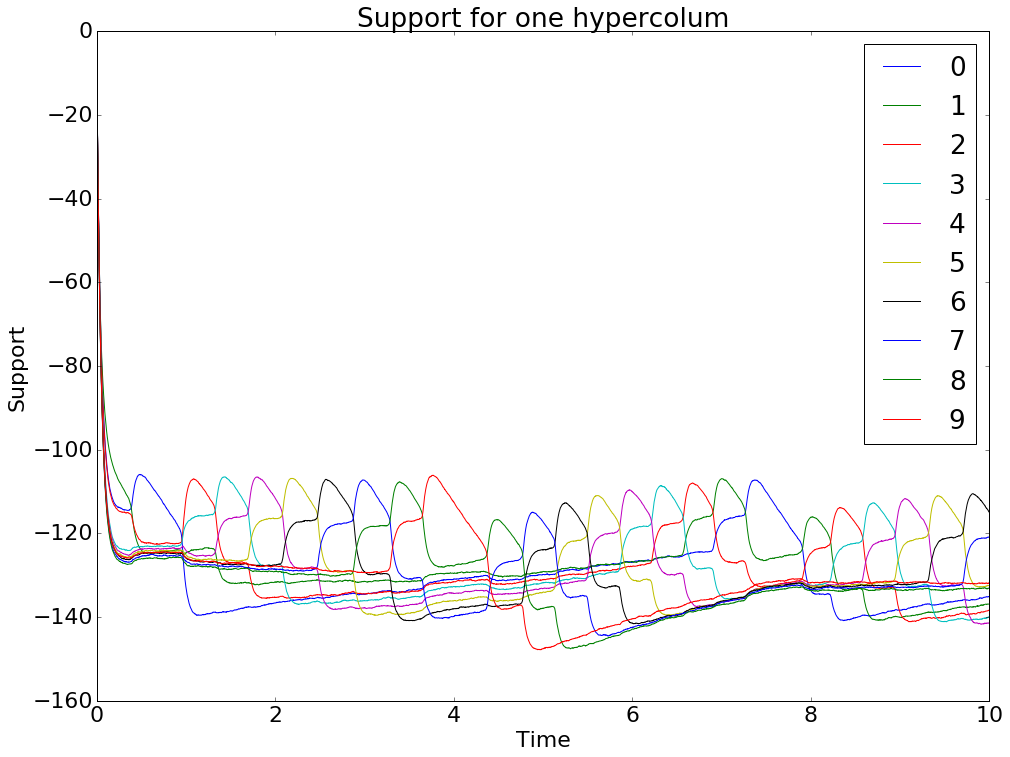

In [17]:
s = history['s']
hypercolum = 0
# a_first = a[:, hypercolum*minicolumns:(hypercolum + 1)*minicolumns + minicolumns]
s_first = s[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, s_unit in enumerate(s_first.T):
    ax.plot(recalling_time, s_unit, label=str(unit))

ax.set_title('Support for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Support')
ax.legend()

#### Unit activity

(-0.1, 1.1)

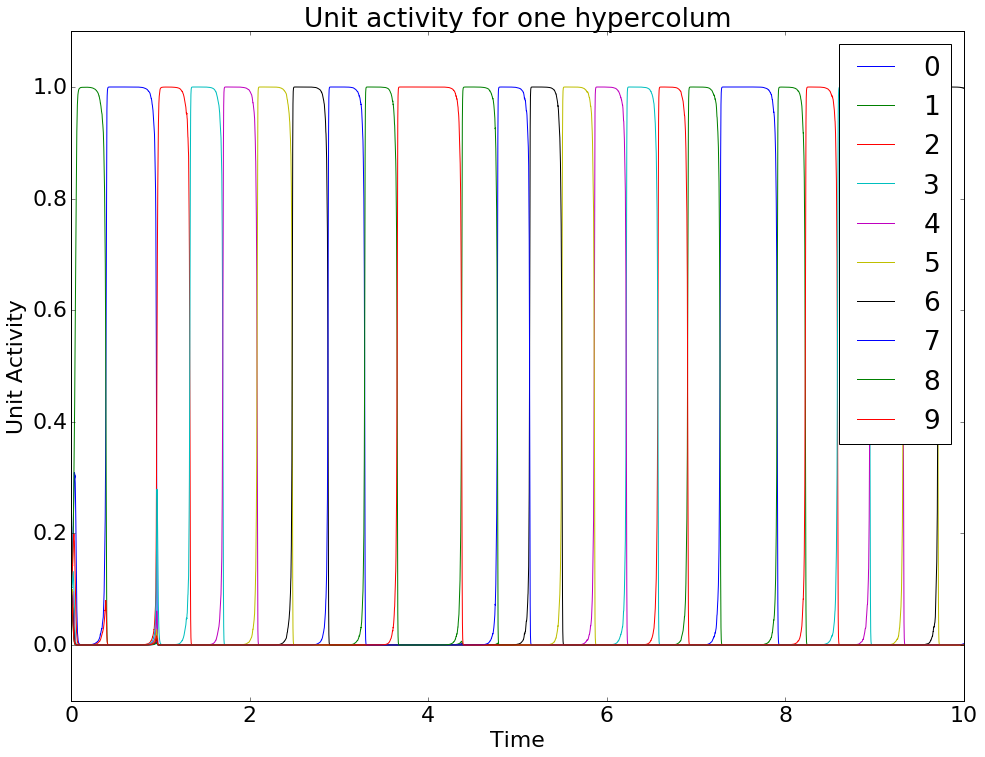

In [18]:
o = history['o']
hypercolum = 0
o_first = o[:, 0:minicolumns]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for unit, o_unit in enumerate(o_first.T):
    ax.plot(recalling_time, o_unit, label=str(unit))

ax.set_title('Unit activity for one hypercolum')
ax.set_xlabel('Time')
ax.set_ylabel('Unit Activity')
ax.legend()

ax.set_ylim([-0.1, 1.1])

#### Git reset

In [19]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])